<a href="https://colab.research.google.com/github/Priyanshu0512/Leukemia-Detection-Qwen3-VL/blob/master/LeukemiaDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1.1 Check GPU
import torch
print("Torch:", torch.__version__, "CUDA available:", torch.cuda.is_available())


Torch: 2.9.0+cu126 CUDA available: True


In [3]:
# 1.2 Install packages (run in a single cell)
# transformers version may need to be recent for Qwen3-VL; HF docs recommend >=4.57
!pip install -q kaggle
!pip install -q "transformers>=4.57.0" accelerate
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q scikit-learn pandas matplotlib seaborn pillow tqdm


In [4]:
# 1.3 Mount Google Drive to save datasets / models
from google.colab import drive
drive.mount('/content/drive')
# Create working directory
!mkdir -p /content/drive/MyDrive/leukemia_ensemble
%cd /content/drive/MyDrive/leukemia_ensemble


Mounted at /content/drive
/content/drive/MyDrive/leukemia_ensemble


In [5]:
from google.colab import files
print("Please upload kaggle.json (Kaggle API token).")
uploaded = files.upload()


Please upload kaggle.json (Kaggle API token).


Saving kaggle.json to kaggle.json


In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
# Replace slug if you prefer another dataset
!kaggle datasets download -d mehradaria/leukemia -p ./kaggle_data
# unzip (filename may be leukemia.zip)
!unzip -q ./kaggle_data/leukemia.zip -d ./kaggle_data
!ls -la ./kaggle_data | sed -n '1,200p'


Dataset URL: https://www.kaggle.com/datasets/mehradaria/leukemia
License(s): ODbL-1.0
 95% 105M/110M [00:00<00:00, 319MB/s] 
100% 110M/110M [00:00<00:00, 328MB/s]
total 113117
-rw------- 1 root root 115823426 Apr 30  2021 leukemia.zip
drwx------ 6 root root      4096 Dec 13 06:48 Original
drwx------ 6 root root      4096 Dec 13 06:49 Segmented


In [8]:
# 3.1 Inspect files (adjust path if necessary)
!find ./kaggle_data -maxdepth 2 -type d -print
!find ./kaggle_data -maxdepth 3 -type f -print | sed -n '1,200p'


./kaggle_data
./kaggle_data/Original
./kaggle_data/Original/Benign
./kaggle_data/Original/Early
./kaggle_data/Original/Pre
./kaggle_data/Original/Pro
./kaggle_data/Segmented
./kaggle_data/Segmented/Benign
./kaggle_data/Segmented/Early
./kaggle_data/Segmented/Pre
./kaggle_data/Segmented/Pro
./kaggle_data/leukemia.zip
./kaggle_data/Original/Benign/WBC-Benign-001.jpg
./kaggle_data/Original/Benign/WBC-Benign-002.jpg
./kaggle_data/Original/Benign/WBC-Benign-003.jpg
./kaggle_data/Original/Benign/WBC-Benign-004.jpg
./kaggle_data/Original/Benign/WBC-Benign-005.jpg
./kaggle_data/Original/Benign/WBC-Benign-006.jpg
./kaggle_data/Original/Benign/WBC-Benign-007.jpg
./kaggle_data/Original/Benign/WBC-Benign-008.jpg
./kaggle_data/Original/Benign/WBC-Benign-009.jpg
./kaggle_data/Original/Benign/WBC-Benign-010.jpg
./kaggle_data/Original/Benign/WBC-Benign-011.jpg
./kaggle_data/Original/Benign/WBC-Benign-012.jpg
./kaggle_data/Original/Benign/WBC-Benign-013.jpg
./kaggle_data/Original/Benign/WBC-Benign-014.

In [9]:
!find ./kaggle_data -maxdepth 3 -type d


./kaggle_data
./kaggle_data/Original
./kaggle_data/Original/Benign
./kaggle_data/Original/Early
./kaggle_data/Original/Pre
./kaggle_data/Original/Pro
./kaggle_data/Segmented
./kaggle_data/Segmented/Benign
./kaggle_data/Segmented/Early
./kaggle_data/Segmented/Pre
./kaggle_data/Segmented/Pro


In [10]:
# CELL 1: Stratified split (70/15/15). Auto-choose Segmented if present.
import os, random, shutil
from glob import glob
from collections import Counter
import math

random.seed(42)

# root where your kaggle_data is mounted
KAGGLE_ROOT = "./kaggle_data"
seg_path = os.path.join(KAGGLE_ROOT, "Segmented")
orig_path = os.path.join(KAGGLE_ROOT, "Original")

# choose source root: prefer Segmented if it exists and non-empty
if os.path.isdir(seg_path) and any(os.scandir(seg_path)):
    src_root = seg_path
    print("Using Segmented images:", src_root)
elif os.path.isdir(orig_path) and any(os.scandir(orig_path)):
    src_root = orig_path
    print("Segmented not found/empty — using Original images:", src_root)
else:
    raise SystemExit("No usable source folder found under ./kaggle_data. Check paths.")

# destination
dst_root = "./dataset"
splits = ["train","val","test"]
ratios = {"train":0.70,"val":0.15,"test":0.15}

# detect classes (subdirectories)
classes = sorted([d for d in os.listdir(src_root) if os.path.isdir(os.path.join(src_root,d))])
if not classes:
    raise SystemExit(f"No class subfolders found under {src_root}.")
print("Detected classes:", classes)

# create dest folders
for sp in splits:
    for cls in classes:
        os.makedirs(os.path.join(dst_root, sp, cls), exist_ok=True)

# perform stratified split per class
for cls in classes:
    files = sorted(glob(os.path.join(src_root, cls, "*")))
    n = len(files)
    if n == 0:
        print(f"Warning: no files for class {cls} in {src_root}/{cls}")
        continue
    random.shuffle(files)
    n_train = int(math.floor(ratios["train"] * n))
    n_val   = int(math.floor(ratios["val"] * n))
    n_test  = n - n_train - n_val
    train_files = files[:n_train]
    val_files   = files[n_train:n_train+n_val]
    test_files  = files[n_train+n_val:]
    # copy (preserve originals)
    for f in train_files:
        shutil.copy(f, os.path.join(dst_root, "train", cls))
    for f in val_files:
        shutil.copy(f, os.path.join(dst_root, "val", cls))
    for f in test_files:
        shutil.copy(f, os.path.join(dst_root, "test", cls))
    print(f"Class {cls}: total={n} -> train={len(train_files)}, val={len(val_files)}, test={len(test_files)}")

# summary counts
def count_all(root):
    out = {}
    for sp in splits:
        for cls in classes:
            c = len(list(glob(os.path.join(root, sp, cls, "*"))))
            out.setdefault(sp, {})[cls] = c
    return out

counts = count_all(dst_root)
print("\nSplit counts:")
for sp in splits:
    print(f" {sp}: ", counts[sp])


Using Segmented images: ./kaggle_data/Segmented
Detected classes: ['Benign', 'Early', 'Pre', 'Pro']
Class Benign: total=504 -> train=352, val=75, test=77
Class Early: total=985 -> train=689, val=147, test=149
Class Pre: total=963 -> train=674, val=144, test=145
Class Pro: total=804 -> train=562, val=120, test=122

Split counts:
 train:  {'Benign': 352, 'Early': 689, 'Pre': 674, 'Pro': 562}
 val:  {'Benign': 75, 'Early': 147, 'Pre': 144, 'Pro': 120}
 test:  {'Benign': 77, 'Early': 149, 'Pre': 145, 'Pro': 122}


In [34]:
# CELL 2: Train ResNet50 (transfer learning) and save test probabilities
# =====================================================
# CELL 2 — Train ResNet50 + Track Loss/Accuracy + Save Test Probabilities
# =====================================================

import os, copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

data_dir = "./dataset"
batch_size = 32
num_epochs = 8
lr = 1e-4
num_workers = 2
input_size = 224

# ---------------------------------------------------
# Data transforms
# ---------------------------------------------------
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

# ---------------------------------------------------
# Load datasets
# ---------------------------------------------------
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x])
                  for x in ['train','val','test']}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x=='train'),
                  num_workers=num_workers)
    for x in ['train','val','test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val','test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Sizes:", dataset_sizes)

# ---------------------------------------------------
# Build model
# ---------------------------------------------------
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# ---------------------------------------------------
# Track history lists
# ---------------------------------------------------
train_loss_list = []
train_acc_list = []
val_acc_list = []

best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

# ---------------------------------------------------
# Training Loop
# ---------------------------------------------------
for epoch in range(num_epochs):

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels).item()

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects / dataset_sizes['train']

    # Save history
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)

    print(f"Train Loss {epoch_loss:.4f} | Train Acc {epoch_acc:.4f}")

    # ---------------------------
    # Validation
    # ---------------------------
    model.eval()
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            val_corrects += torch.sum(preds == labels).item()

    val_acc = val_corrects / dataset_sizes['val']
    val_acc_list.append(val_acc)

    print(f"Val Acc {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, "best_resnet50.pth")

print("\nBest Validation Acc:", best_acc)

# Load best model
model.load_state_dict(best_model_wts)

# ---------------------------------------------------
# Evaluate on Test Set + Save Probabilities
# ---------------------------------------------------
model.eval()
y_true = []
y_pred = []
y_probas = []

test_samples = image_datasets['test'].samples
image_paths = [p for p,_ in test_samples]

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        y_probas.extend(probs)

# Save test results for ensemble
with open("cnn_test_results.pkl", "wb") as f:
    pickle.dump({
        "y_true": y_true,
        "y_pred": y_pred,
        "y_probas": y_probas,
        "image_paths": image_paths,
        "class_names": class_names
    }, f)

print("\nSaved cnn_test_results.pkl")
print("Test Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Device: cuda
Classes: ['Benign', 'Early', 'Pre', 'Pro']
Sizes: {'train': 2277, 'val': 486, 'test': 493}


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/8
Train Loss 0.2264 | Train Acc 0.9262
Val Acc 0.9527

Epoch 2/8
Train Loss 0.0886 | Train Acc 0.9710
Val Acc 0.9815

Epoch 3/8
Train Loss 0.0649 | Train Acc 0.9789
Val Acc 0.9712

Epoch 4/8
Train Loss 0.0318 | Train Acc 0.9899
Val Acc 0.9835

Epoch 5/8
Train Loss 0.0459 | Train Acc 0.9859
Val Acc 0.9938

Epoch 6/8
Train Loss 0.0172 | Train Acc 0.9943
Val Acc 0.9959

Epoch 7/8
Train Loss 0.0189 | Train Acc 0.9930
Val Acc 0.9897

Epoch 8/8
Train Loss 0.0435 | Train Acc 0.9877
Val Acc 0.9712

Best Validation Acc: 0.9958847736625515

Saved cnn_test_results.pkl
Test Report:
              precision    recall  f1-score   support

      Benign       0.99      0.97      0.98        77
       Early       0.98      0.99      0.98       149
         Pre       0.99      0.99      0.99       145
         Pro       1.00      1.00      1.00       122

    accuracy                           0.99       493
   macro avg       0.99      0.99      0.99       493
weighted avg       0.99      0.99 

In [12]:
# CELL 5 — Load Qwen3-VL and implement sampling-based probability estimator
# Paste this into Colab and run.

import os
import torch
from PIL import Image
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor

# Choose model: start small
MODEL_NAME = "Qwen/Qwen3-VL-2B-Instruct"   # change if needed

print("Loading Qwen3-VL model:", MODEL_NAME)
try:
    qwen_model = Qwen3VLForConditionalGeneration.from_pretrained(
        MODEL_NAME,
        device_map="auto",            # auto place on GPU/CPU
        torch_dtype=torch.float16,    # float16 helps memory on GPU
        low_cpu_mem_usage=True
    )
    qwen_processor = AutoProcessor.from_pretrained(MODEL_NAME)
    qwen_model.eval()
    print("Loaded Qwen3-VL successfully.")
except Exception as e:
    print("Error loading model:", e)
    print("If this OOMs, try a smaller model or set device_map={'': 'cpu'} (very slow).")
    raise

# Build classification prompt messages
def build_messages_for_classify(pil_image, label_space):
    label_str = ", ".join(label_space)
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": pil_image},
                {
                    "type": "text",
                    "text": (
                        "You are an expert hematologist. "
                        "Classify this blood smear image as exactly one of: "
                        f"{label_str}. Reply with only the class name (no extra text)."
                    ),
                },
            ],
        }
    ]
    return messages

# Sampling-based probability estimation
def qwen_sample_probs(pil_image, label_space, model, proc, n_samples=8, temperature=1.0, max_new_tokens=8):
    """
    For a single PIL image, sample the model `n_samples` times and count label frequencies.
    Returns: probs (list of floats len=C), counts (dict)
    """
    messages = build_messages_for_classify(pil_image, label_space)
    # tokenize & image process
    inputs = proc.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
        return_dict=True
    )
    # remove token_type_ids if present (HF doc)
    inputs.pop("token_type_ids", None)

    # Move tensors to model device
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    counts = {cls: 0 for cls in label_space}
    for i in range(n_samples):
        with torch.no_grad():
            # do_sample True to get stochastic outputs
            gen_ids = model.generate(
                **inputs,
                do_sample=True,
                temperature=temperature,
                top_p=0.95,
                max_new_tokens=max_new_tokens,
                num_return_sequences=1
            )
        # trim prompt tokens — each generated sequence contains input prompt + generated
        # Note: inputs["input_ids"] shape: (1, L_in)
        generated = gen_ids[0]
        prompt_len = inputs["input_ids"].shape[1]
        trimmed = generated[prompt_len:]
        text = proc.batch_decode(trimmed.unsqueeze(0), skip_special_tokens=True, clean_up_tokenization_spaces=False)[0].strip().lower()
        matched = False
        for cls in label_space:
            if cls.lower() in text:
                counts[cls] += 1
                matched = True
                break
        if not matched:
            # fallback: match first token / first word of output
            first = text.split()
            if first:
                first_lower = first[0].strip().lower()
                for cls in label_space:
                    if cls.lower().startswith(first_lower):
                        counts[cls] += 1
                        matched = True
                        break
        # if still unmatched, ignore this sample (it doesn't increment counts)
    total = sum(counts.values())
    if total == 0:
        # fallback to uniform
        probs = [1.0 / len(label_space)] * len(label_space)
    else:
        probs = [counts[cls] / total for cls in label_space]
    return probs, counts


`torch_dtype` is deprecated! Use `dtype` instead!


Loading Qwen3-VL model: Qwen/Qwen3-VL-2B-Instruct


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/4.26G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/269 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

Loaded Qwen3-VL successfully.


In [13]:
# CELL 6 — Compute Qwen sampled probabilities for val and test sets
# This may take time. Reduce n_samples or run only on subset if needed.

import pickle, time, tqdm
from glob import glob
from PIL import Image

# Paths for dataset splits
val_root = "./dataset/val"
test_root = "./dataset/test"

# detect class names from dataset folder (assume train/val/test share same class names)
classes = sorted([d for d in os.listdir("./dataset/train") if os.path.isdir(os.path.join("./dataset/train", d))])
print("Detected classes:", classes)

# build list of (image_path, class_idx) for val and test
def list_images(root, classes):
    samples = []
    for idx, cls in enumerate(classes):
        cls_files = sorted(glob(os.path.join(root, cls, "*")))
        for p in cls_files:
            samples.append((p, idx))
    return samples

val_samples = list_images(val_root, classes)
test_samples = list_images(test_root, classes)
print(f"Val images: {len(val_samples)}  Test images: {len(test_samples)}")

# sampling params
n_samples = 6        # start small; increase for stability
temperature = 0.9
max_new_tokens = 8

# function to compute for a list of samples
def compute_probs_for_samples(samples, classes, model, proc, n_samples, temperature, max_new_tokens):
    probs_list = []
    counts_list = []
    paths = []
    t0 = time.time()
    for (p, idx) in tqdm.tqdm(samples):
        try:
            pil = Image.open(p).convert("RGB")
        except Exception as e:
            print("Error loading", p, e)
            probs_list.append([1.0/len(classes)]*len(classes))
            counts_list.append({cls:0 for cls in classes})
            paths.append(p)
            continue
        probs, counts = qwen_sample_probs(pil, classes, model, proc, n_samples=n_samples, temperature=temperature, max_new_tokens=max_new_tokens)
        probs_list.append(probs)
        counts_list.append(counts)
        paths.append(p)
    t1 = time.time()
    print(f"Computed {len(samples)} items in {t1 - t0:.1f}s")
    return paths, probs_list, counts_list

print("Computing val set Qwen probs...")
val_paths, val_qwen_probas, val_qwen_counts = compute_probs_for_samples(val_samples, classes, qwen_model, qwen_processor, n_samples, temperature, max_new_tokens)

print("Computing test set Qwen probs...")
test_paths, test_qwen_probas, test_qwen_counts = compute_probs_for_samples(test_samples, classes, qwen_model, qwen_processor, n_samples, temperature, max_new_tokens)

# Save results
os.makedirs("qwen_results", exist_ok=True)
with open("qwen_results/qwen_val_results.pkl", "wb") as f:
    pickle.dump({'paths':val_paths, 'probas':val_qwen_probas, 'counts':val_qwen_counts, 'classes':classes}, f)
with open("qwen_results/qwen_test_results.pkl", "wb") as f:
    pickle.dump({'paths':test_paths, 'probas':test_qwen_probas, 'counts':test_qwen_counts, 'classes':classes}, f)

print("Saved Qwen results to qwen_results/")


Detected classes: ['Benign', 'Early', 'Pre', 'Pro']
Val images: 486  Test images: 493
Computing val set Qwen probs...


100%|██████████| 486/486 [1:52:10<00:00, 13.85s/it]


Computed 486 items in 6730.0s
Computing test set Qwen probs...


100%|██████████| 493/493 [1:52:52<00:00, 13.74s/it]

Computed 493 items in 6772.2s
Saved Qwen results to qwen_results/


In [16]:
# =====================================================
# CELL 7 — ENSEMBLE FUSION + TEST SET EVALUATION
# =====================================================

import pickle, numpy as np, os
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

# ------------------------
# Load CNN test results
# ------------------------
with open("cnn_test_results.pkl", "rb") as f:
    cnn_results = pickle.load(f)

cnn_y_true = np.array(cnn_results["y_true"])
cnn_test_probas = np.array(cnn_results["y_probas"])   # shape: (N_test, C)
cnn_test_paths = cnn_results["image_paths"]
classes = cnn_results["class_names"]

print("Loaded CNN test results:", cnn_test_probas.shape)

# ------------------------
# Load Qwen test results
# ------------------------
with open("qwen_results/qwen_test_results.pkl", "rb") as f:
    qwen_test = pickle.load(f)

qwen_test_paths = qwen_test["paths"]
qwen_test_probas = np.array(qwen_test["probas"])      # shape: (N_test, C)
qwen_classes = qwen_test["classes"]

print("Loaded Qwen test results:", qwen_test_probas.shape)

# ------------------------
# Align Qwen results with CNN image order
# ------------------------
path_to_qidx = {os.path.abspath(p): i for i, p in enumerate(qwen_test_paths)}

aligned_qwen_probas = []
missing_count = 0

for p in cnn_test_paths:
    abs_p = os.path.abspath(p)
    if abs_p in path_to_qidx:
        aligned_qwen_probas.append(qwen_test_probas[path_to_qidx[abs_p]])
    else:
        # fallback: match by filename
        base = os.path.basename(p)
        match = None
        for i, qp in enumerate(qwen_test_paths):
            if os.path.basename(qp) == base:
                match = i
                break
        if match is not None:
            aligned_qwen_probas.append(qwen_test_probas[match])
        else:
            # worst-case fallback: uniform probability
            missing_count += 1
            aligned_qwen_probas.append(np.ones(len(classes)) / len(classes))

aligned_qwen_probas = np.array(aligned_qwen_probas)

print("Aligned shapes — CNN:", cnn_test_probas.shape,
      "Qwen:", aligned_qwen_probas.shape)
print("Missing matches:", missing_count)

# ------------------------
# Ensemble fusion — try different alphas
# ------------------------
def evaluate_fusion(alpha):
    fusion = alpha * cnn_test_probas + (1 - alpha) * aligned_qwen_probas
    preds = np.argmax(fusion, axis=1)
    acc = accuracy_score(cnn_y_true, preds)
    return acc, preds

alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
best_alpha = None
best_acc = -1

for a in alphas:
    acc, _ = evaluate_fusion(a)
    print(f"alpha={a} → accuracy={acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_alpha = a

print("\nBest alpha =", best_alpha, "with accuracy =", best_acc)

# ------------------------
# Final evaluation using best alpha
# ------------------------
final_fusion = best_alpha * cnn_test_probas + (1 - best_alpha) * aligned_qwen_probas
final_preds = np.argmax(final_fusion, axis=1)

print("\nFinal classification report:")
print(classification_report(cnn_y_true, final_preds, target_names=classes))

print("Confusion matrix:")
print(confusion_matrix(cnn_y_true, final_preds))

# ------------------------
# Save ensemble results
# ------------------------
df = pd.DataFrame({
    "image_path": cnn_test_paths,
    "true": cnn_y_true,
    "cnn_pred": np.argmax(cnn_test_probas, axis=1),
    "ensemble_pred": final_preds
})

df.to_csv("ensemble_results_test.csv", index=False)
print("\nSaved: ensemble_results_test.csv")


Loaded CNN test results: (493, 4)
Loaded Qwen test results: (493, 4)
Aligned shapes — CNN: (493, 4) Qwen: (493, 4)
Missing matches: 0
alpha=0.0 → accuracy=0.2069
alpha=0.25 → accuracy=0.4828
alpha=0.5 → accuracy=0.9878
alpha=0.75 → accuracy=0.9858
alpha=1.0 → accuracy=0.9858

Best alpha = 0.5 with accuracy = 0.9878296146044625

Final classification report:
              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        77
       Early       0.99      0.99      0.99       149
         Pre       0.99      1.00      1.00       145
         Pro       1.00      0.98      0.99       122

    accuracy                           0.99       493
   macro avg       0.99      0.98      0.98       493
weighted avg       0.99      0.99      0.99       493

Confusion matrix:
[[ 74   2   1   0]
 [  1 148   0   0]
 [  0   0 145   0]
 [  2   0   0 120]]

Saved: ensemble_results_test.csv


In [17]:
# Compute CNN validation probabilities (only if missing)
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_eval = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_data = datasets.ImageFolder("./dataset/val", transform=transform_eval)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Load trained CNN
import torchvision.models as models
import torch.nn as nn

model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model.load_state_dict(torch.load("best_resnet50.pth", map_location=device))
model.to(device).eval()

cnn_val_probas = []
y_val_true = []

import numpy as np

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        out = model(x)
        prob = torch.softmax(out, dim=1).cpu().numpy()
        cnn_val_probas.extend(prob)
        y_val_true.extend(y.numpy())

cnn_val_probas = np.array(cnn_val_probas)
y_val_true = np.array(y_val_true)

np.save("cnn_val_probas.npy", cnn_val_probas)
np.save("y_val_true.npy", y_val_true)

print("Saved CNN validation probabilities.")


Saved CNN validation probabilities.


In [18]:
# =====================================================
# CELL 8 — TUNE ALPHA ON VALIDATION SET
# =====================================================

import numpy as np
import pickle
from sklearn.metrics import accuracy_score

# Load CNN val probabilities
cnn_val_probas = np.load("cnn_val_probas.npy")
y_val_true = np.load("y_val_true.npy")

# Load Qwen val probabilities
with open("qwen_results/qwen_val_results.pkl", "rb") as f:
    qwen_val = pickle.load(f)

qwen_val_probas = np.array(qwen_val["probas"])

alphas = np.linspace(0, 1, 21)
best_alpha = None
best_acc = -1

for a in alphas:
    fused = a * cnn_val_probas + (1 - a) * qwen_val_probas
    preds = np.argmax(fused, axis=1)
    acc = accuracy_score(y_val_true, preds)
    print(f"alpha={a:.2f} → val accuracy={acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_alpha = a

print("\nBEST ALPHA =", best_alpha)
print("Validation accuracy =", best_acc)


alpha=0.00 → val accuracy=0.2037
alpha=0.05 → val accuracy=0.2860
alpha=0.10 → val accuracy=0.2860
alpha=0.15 → val accuracy=0.4835
alpha=0.20 → val accuracy=0.4835
alpha=0.25 → val accuracy=0.4835
alpha=0.30 → val accuracy=0.6811
alpha=0.35 → val accuracy=0.8621
alpha=0.40 → val accuracy=0.8704
alpha=0.45 → val accuracy=0.9753
alpha=0.50 → val accuracy=0.9897
alpha=0.55 → val accuracy=0.9938
alpha=0.60 → val accuracy=0.9959
alpha=0.65 → val accuracy=0.9959
alpha=0.70 → val accuracy=0.9959
alpha=0.75 → val accuracy=0.9938
alpha=0.80 → val accuracy=0.9938
alpha=0.85 → val accuracy=0.9938
alpha=0.90 → val accuracy=0.9938
alpha=0.95 → val accuracy=0.9938
alpha=1.00 → val accuracy=0.9938

BEST ALPHA = 0.6000000000000001
Validation accuracy = 0.9958847736625515


In [35]:
# =====================================================
# SAFE SAVE FINAL FILES TO DRIVE (no SameFileError)
# =====================================================

import os, shutil

target_dir = "/content/drive/MyDrive/leukemia_ensemble"
os.makedirs(target_dir, exist_ok=True)

files_to_save = [
    "best_resnet50.pth",
    "cnn_test_results.pkl",
    "ensemble_results_test.csv",
    "qwen_results/qwen_test_results.pkl",
    "qwen_results/qwen_val_results.pkl",
    "cnn_val_probas.npy",
    "y_val_true.npy",
]

for f in files_to_save:
    if not os.path.exists(f):
        print(f"❌ SKIPPED (file not found): {f}")
        continue

    dest_path = os.path.join(target_dir, os.path.basename(f))

    # If source and destination are the same → skip
    if os.path.abspath(f) == os.path.abspath(dest_path):
        print(f"⚠️ Already in Drive, skipping: {f}")
        continue

    # If destination exists → overwrite safely
    if os.path.exists(dest_path):
        os.remove(dest_path)

    shutil.copy(f, dest_path)
    print(f"✅ Saved: {f} → {dest_path}")

print("\n🎉 All available files saved safely!")


⚠️ Already in Drive, skipping: best_resnet50.pth
⚠️ Already in Drive, skipping: cnn_test_results.pkl
⚠️ Already in Drive, skipping: ensemble_results_test.csv
✅ Saved: qwen_results/qwen_test_results.pkl → /content/drive/MyDrive/leukemia_ensemble/qwen_test_results.pkl
✅ Saved: qwen_results/qwen_val_results.pkl → /content/drive/MyDrive/leukemia_ensemble/qwen_val_results.pkl
⚠️ Already in Drive, skipping: cnn_val_probas.npy
⚠️ Already in Drive, skipping: y_val_true.npy

🎉 All available files saved safely!


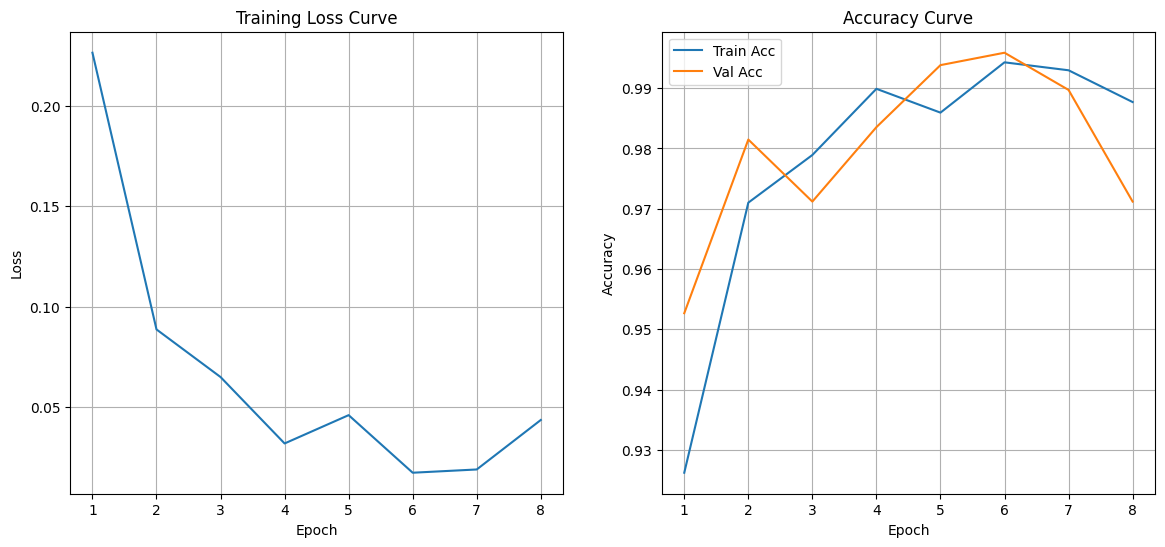

In [36]:
import matplotlib.pyplot as plt

# If you saved history as arrays:
# Suppose you kept train_acc_list, val_acc_list, train_loss_list
# If not, skip this section

if 'train_acc_list' in globals():
    epochs = range(1, len(train_acc_list)+1)

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss_list, label='Train Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc_list, label='Train Acc')
    plt.plot(epochs, val_acc_list, label='Val Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


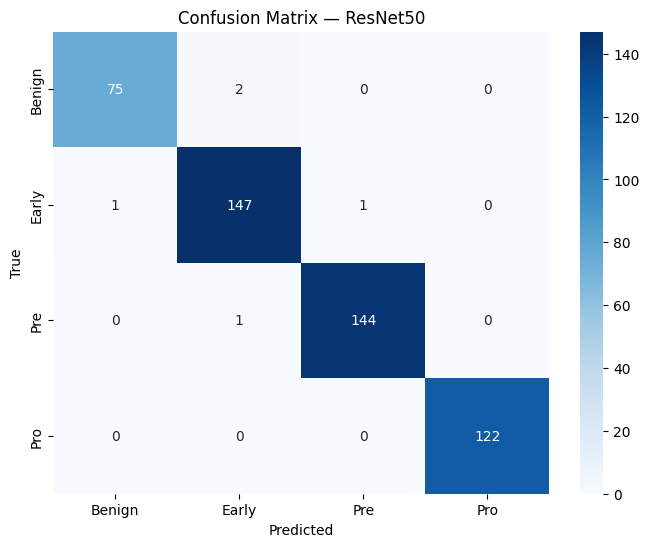

In [37]:
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load saved results
with open("cnn_test_results.pkl","rb") as f:
    cnn = pickle.load(f)

y_true = np.array(cnn["y_true"])
y_pred = np.array(cnn["y_pred"])
classes = cnn["class_names"]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — ResNet50")
plt.show()


In [38]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.style.background_gradient(cmap='Blues')


,precision,recall,f1-score,support
Benign,0.986842,0.974026,0.980392,77.000000
Early,0.980000,0.986577,0.983278,149.000000
Pre,0.993103,0.993103,0.993103,145.000000
Pro,1.000000,1.000000,1.000000,122.000000
accuracy,0.989858,0.989858,0.989858,0.989858
macro avg,0.989986,0.988427,0.989193,493.000000
weighted avg,0.989872,0.989858,0.989855,493.000000


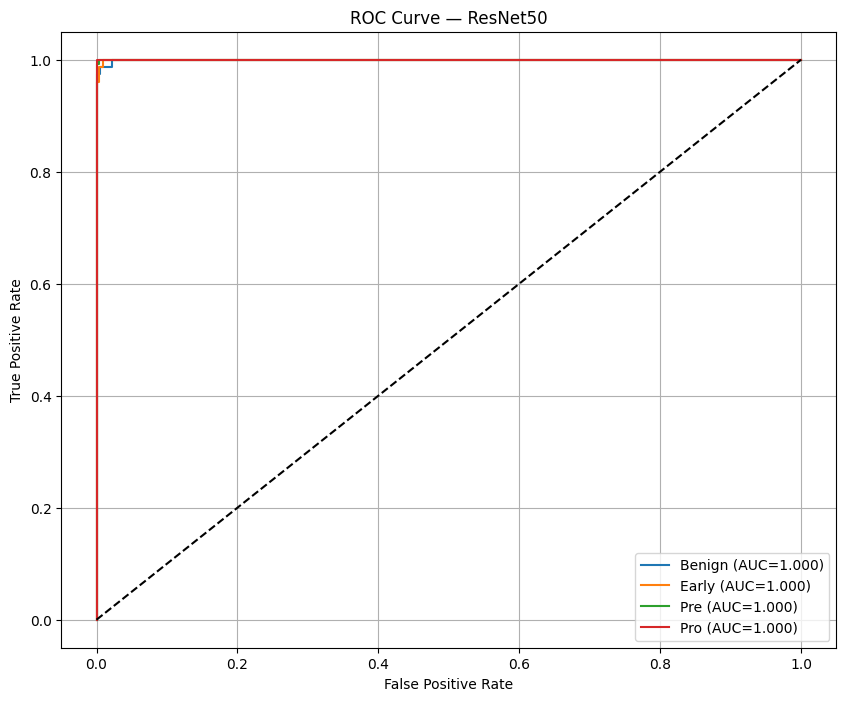

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

probas = np.array(cnn["y_probas"])
y_bin = label_binarize(y_true, classes=list(range(len(classes))))

plt.figure(figsize=(10,8))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probas[:, i])
    score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={score:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — ResNet50")
plt.legend()
plt.grid()
plt.show()


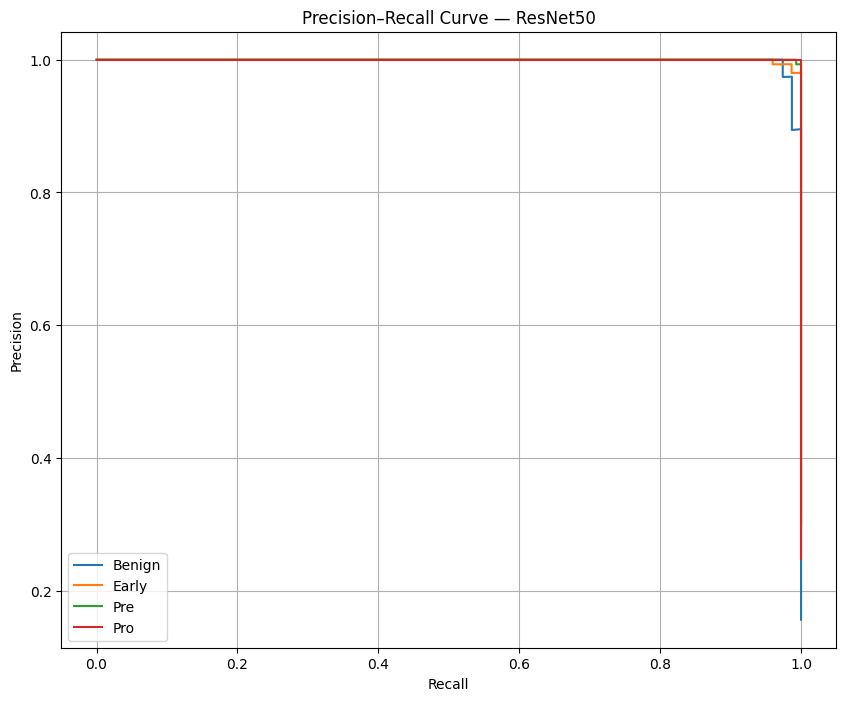

In [40]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(10,8))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], probas[:, i])
    plt.plot(recall, precision, label=f"{cls}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — ResNet50")
plt.legend()
plt.grid()
plt.show()


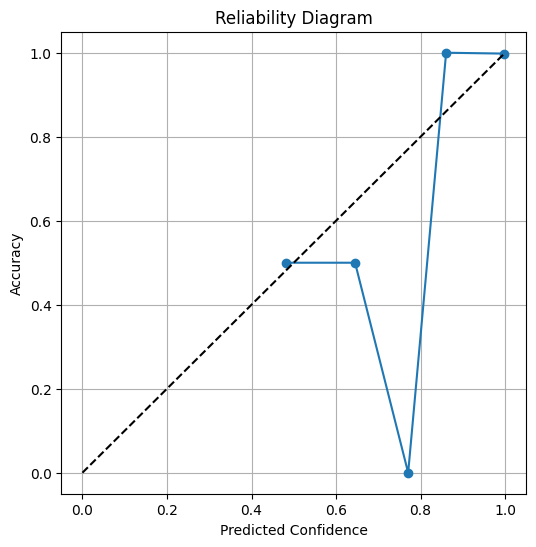

ECE = 0.005288735606365714


In [41]:
from sklearn.calibration import calibration_curve

pred_conf = np.max(probas, axis=1)
correct = (y_pred == y_true).astype(int)

prob_true, prob_pred = calibration_curve(correct, pred_conf, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Predicted Confidence")
plt.ylabel("Accuracy")
plt.title("Reliability Diagram")
plt.grid()
plt.show()

# ECE
def ece(preds, confs, y_true, bins=10):
    bin_bounds = np.linspace(0,1,bins+1)
    total = len(y_true)
    ece = 0
    for i in range(bins):
        mask = (confs>bin_bounds[i]) & (confs<=bin_bounds[i+1])
        if mask.sum()==0: continue
        acc = (preds[mask]==y_true[mask]).mean()
        conf = confs[mask].mean()
        ece += (mask.sum()/total)*abs(acc-conf)
    return ece

print("ECE =", ece(y_pred, pred_conf, y_true))


Misclassified count: 5


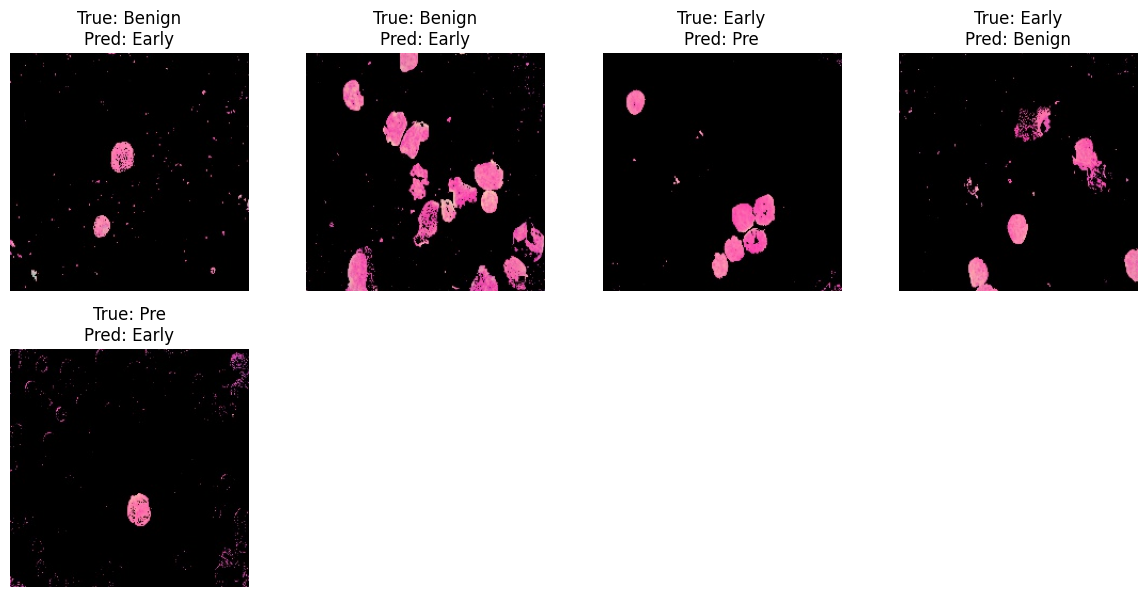

In [42]:
from PIL import Image
import matplotlib.pyplot as plt

image_paths = cnn["image_paths"]
mis_idx = np.where(y_true != y_pred)[0]
print("Misclassified count:", len(mis_idx))

plt.figure(figsize=(12,12))
for i, idx in enumerate(mis_idx[:16]):  # show first 16 errors
    img = Image.open(image_paths[idx])
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.title(f"True: {classes[y_true[idx]]}\nPred: {classes[y_pred[idx]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [46]:
import pickle, numpy as np

with open("cnn_test_results.pkl", "rb") as f:
    cnn = pickle.load(f)

cnn_y_true  = np.array(cnn["y_true"])
cnn_y_pred  = np.array(cnn["y_pred"])
cnn_probas  = np.array(cnn["y_probas"])
cnn_paths   = cnn["image_paths"]
cnn_classes = cnn["class_names"]

print("Loaded CNN results. Shapes:")
print("y_true:", cnn_y_true.shape)
print("y_pred:", cnn_y_pred.shape)
print("probas:", cnn_probas.shape)


Loaded CNN results. Shapes:
y_true: (493,)
y_pred: (493,)
probas: (493, 4)


In [47]:
import pandas as pd
df = pd.read_csv("ensemble_results_test.csv")

final_preds = df["ensemble_pred"].values


In [48]:
import numpy as np

cnn_wrong = np.where(cnn_y_pred != cnn_y_true)[0]
ens_correct = np.where(final_preds == cnn_y_true)[0]

rescued = np.intersect1d(cnn_wrong, ens_correct)

print("CNN wrong:", len(cnn_wrong))
print("Ensemble correct:", len(ens_correct))
print("Ensemble rescued cases:", len(rescued))


CNN wrong: 5
Ensemble correct: 487
Ensemble rescued cases: 2


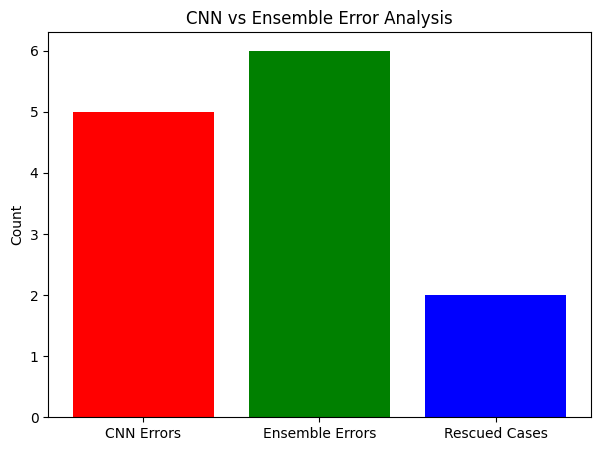

In [49]:
import matplotlib.pyplot as plt

cnn_errors = len(np.where(cnn_y_pred != cnn_y_true)[0])
ens_errors = len(np.where(final_preds != cnn_y_true)[0])
rescued = len(rescued)

plt.figure(figsize=(7,5))
plt.bar(["CNN Errors", "Ensemble Errors", "Rescued Cases"],
        [cnn_errors, ens_errors, rescued],
        color=["red","green","blue"])
plt.ylabel("Count")
plt.title("CNN vs Ensemble Error Analysis")
plt.show()


In [51]:
import numpy as np

cnn_wrong = np.where(cnn_y_pred != cnn_y_true)[0]
ens_correct = np.where(final_preds == cnn_y_true)[0]

rescued = np.intersect1d(cnn_wrong, ens_correct)

print("Rescued cases:", rescued)
print("Count:", len(rescued))


Rescued cases: [154 226]
Count: 2


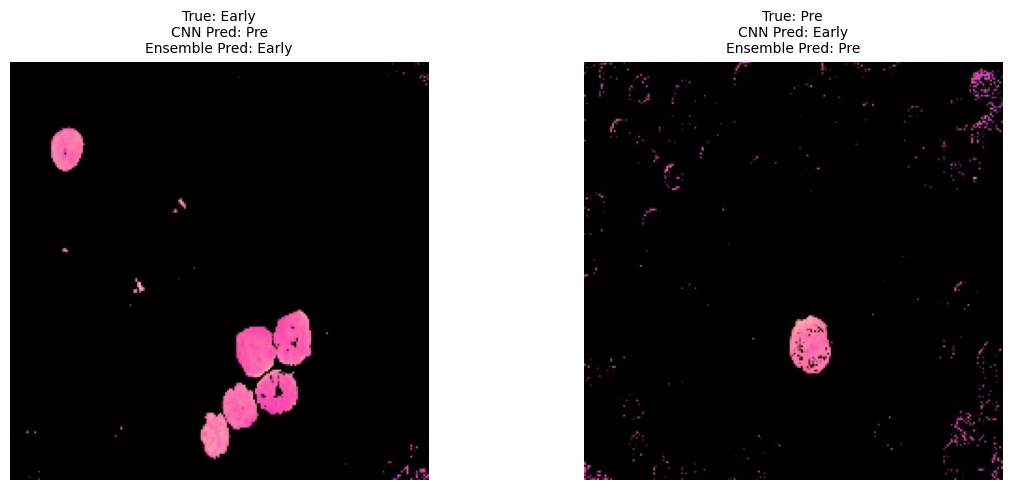

In [53]:
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

for i, idx in enumerate(rescued):
    img = Image.open(cnn_paths[idx])

    true_label = cnn_classes[cnn_y_true[idx]]
    cnn_wrong_pred = cnn_classes[cnn_y_pred[idx]]
    ens_correct_pred = cnn_classes[final_preds[idx]]

    plt.subplot(1, len(rescued), i+1)
    plt.imshow(img)
    plt.title(
        f"True: {true_label}\n"
        f"CNN Pred: {cnn_wrong_pred}\n"
        f"Ensemble Pred: {ens_correct_pred}",
        fontsize=10
    )
    plt.axis("off")

plt.tight_layout()
plt.show()
